In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)
from botorch.utils.sampling import draw_sobol_samples
from torchcubicspline import natural_cubic_spline_coeffs, NaturalCubicSpline

In [2]:
def gold_dielectric_function(x):
    wl = 1239.19/torch.tensor([0.1,0.2,0.3,0.4,0.5,0.5450000,0.5910000,0.6360000,0.64,0.77,0.89,
                           1.02,1.14,1.26,1.39,1.51,1.64,1.76,1.88,2.01,2.13,2.26,2.38,2.50,
                           2.63,2.75,2.88,3.00,3.12,3.25,3.37,3.50,3.62,3.74,3.87,3.99,4.12,
                           4.24,4.36,4.49,4.61,4.74,4.86,4.98,5.11,5.23,5.36,5.48,5.60])
    n_real = torch.tensor([25.17233,7.60352,3.53258,2.02586,1.299091,1.097350,0.9394755,
                       0.8141369,0.92,0.56,0.43,0.35,0.27,0.22,0.17,0.16,0.14,0.13,0.14,
                       0.21,0.29,0.43,0.62,1.04,1.31,1.38,1.45,1.46,1.47,1.46,1.48,1.50,
                       1.48,1.48,1.54,1.53,1.53,1.49,1.47,1.43,1.38,1.35,1.33,1.33,
                       1.32,1.32,1.30,1.31,1.30])
    n_imag = torch.tensor([77.92804,43.34848,29.52751,22.25181,17.77038,16.24777,
                       14.94747,13.82771,13.78,11.21,9.519,8.145,7.15,6.35,5.66,
                       5.08,4.542,4.103,3.697,3.272,2.863,2.455,2.081,1.833,1.849,
                       1.914,1.948,1.958,1.952,1.933,1.895,1.866,1.871,1.883,1.898,
                       1.893,1.889,1.878,1.869,1.847,1.803,1.749,1.688,1.631,1.577,
                       1.536,1.497,1.460,1.427])
    n_r = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_real, [0]).reshape(-1,1)))
    n_i = NaturalCubicSpline(natural_cubic_spline_coeffs(torch.flip(wl, [0]), torch.flip(n_imag, [0]).reshape(-1,1)))
    eps = (n_r.evaluate(x) + 1j*n_i.evaluate(x))**2
   
    return eps.real, eps.imag

In [3]:
def sphere_extinction(wavelength, radius, em):
    e1, e2 = gold_dielectric_function(wavelength)
    e = torch.complex(e1, e2)

    factor = (e-em)/(e+2*em)
    scale = (4 * np.pi * (radius**1.5)) / (3 * wavelength)
    gamma = scale*factor.imag

    return gamma 

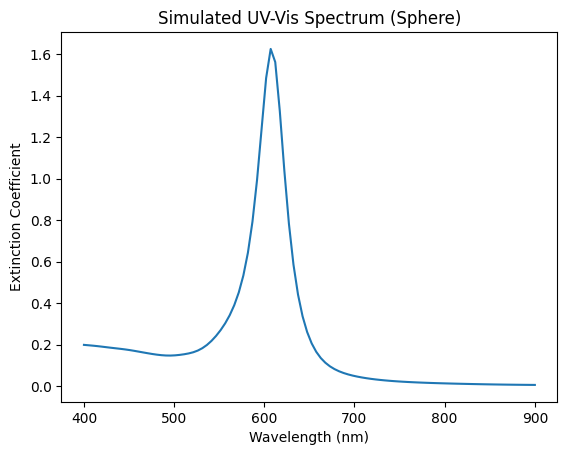

In [4]:
radius = torch.Tensor([8.0])
em = torch.Tensor([5.0])
wavelengths = torch.linspace(400, 900, 100)
spectra_sphere = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_sphere[i] = sphere_extinction(wl, radius, em)

plt.plot(wavelengths, spectra_sphere.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Sphere)")
plt.show()

In [5]:
def nanorod_extinction(wavelength, length, radius, em):
    e1, e2 = gold_dielectric_function(wavelength)
    scale = (2 * np.pi * (em**1.5)) / (3 * wavelength)
    ar = length/radius
    e = torch.sqrt(1 - (1 / ar)**2)
    PA = ( (1 - e**2)/ e**2 ) * ( ((1/ (2 * e)) * torch.log((1 + e) / (1 - e))) - 1 )
    PB = 0.5 * (1 - PA) 
    PC = 0.5 * (1 - PA)
    gamma = 0.0
    for P in [PA, PB, PC]:
        gj = (e2/ (P**2) )/( ( e1 + (((1-P)/P)*em) )**2 + e2**2)
        gamma += gj

    ext = scale*gamma

    return ext    

(array([ 1.,  1.,  3.,  5.,  8., 11., 14., 16., 19., 22.]),
 array([400.00008128, 450.00006454, 500.0000478 , 550.00003106,
        600.00001432, 649.99999758, 699.99998084, 749.9999641 ,
        799.99994736, 849.99993062, 899.99991388]),
 <BarContainer object of 10 artists>)

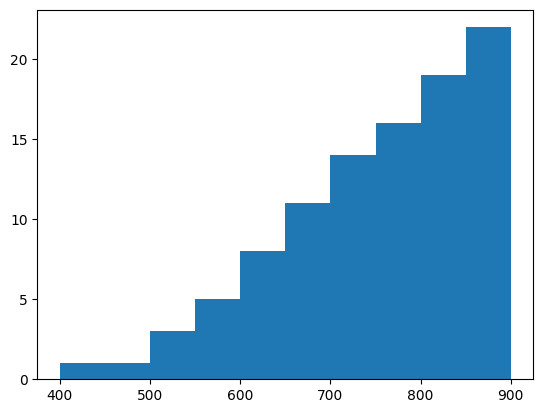

In [6]:
def biased_log_sample(start, end, steps, bias=2.0):
    """
    Generate logarithmically spaced samples with a bias towards the end.
    :param start: Start value (inclusive).
    :param end: End value (inclusive).
    :param steps: Number of samples.
    :param bias: Controls bias; >1 biases towards the start, <1 biases towards the end.
    :return: Tensor with biased logarithmically spaced values.
    """
    log_start = torch.log10(torch.tensor(start, dtype=torch.float32))
    log_end = torch.log10(torch.tensor(end, dtype=torch.float32))
    
    # Create a biased space (bias > 1 shifts samples towards the end)
    linear_space = torch.linspace(0, 1, steps)**bias
    
    # Map linear space to log space
    log_space = log_start + linear_space * (log_end - log_start)
    return torch.pow(10, log_space)

# Example usage
samples = biased_log_sample(400, 900, 100, bias=0.3)  # Bias < 1 for more samples near the end

plt.hist(samples)


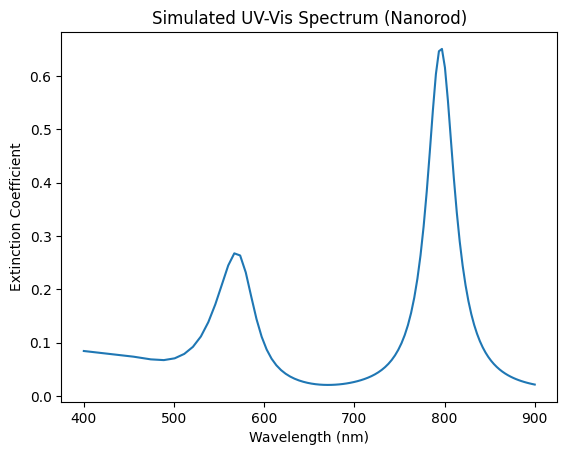

In [7]:
length = torch.Tensor([40.0])
radius = torch.Tensor([20.0])
em = torch.Tensor([5.0])
wavelengths = biased_log_sample(400, 900, 100, bias=0.4)
spectra_nanorod = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_nanorod[i] = nanorod_extinction(wl, length, radius, em)

plt.plot(wavelengths, spectra_nanorod.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Nanorod)")
plt.show()

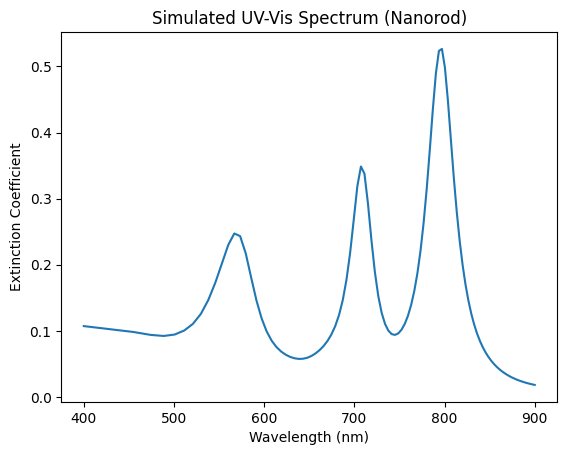

In [8]:
alpha = 0.8
spectra_mixture = (1-alpha)*spectra_sphere + alpha*spectra_nanorod
plt.plot(wavelengths, spectra_mixture.detach().numpy())
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extinction Coefficient")
plt.title("Simulated UV-Vis Spectrum (Nanorod)")
plt.show()

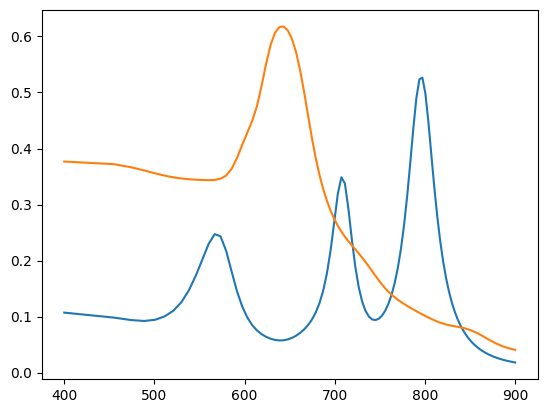

In [10]:
DATA_DIR = "/Users/pozzolabadmin/Documents/codebase/experiments/aunp_seed_mediated_phasemap/01_112724_phasemapping"
grid_data = np.load(DATA_DIR+"/paper/data/grid_data_10_14.npz")

target_spectra = grid_data["spectra"][30, :, 0]

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_mixture.detach().numpy())
ax.plot(wavelengths, target_spectra)
plt.show()

Loading data from iteration 0 with shapes: (12, 2) (12, 101)
Loading data from iteration 1 with shapes: (6, 2) (6, 101)
Loading data from iteration 2 with shapes: (6, 2) (6, 101)
Loading data from iteration 3 with shapes: (6, 2) (6, 101)
Loading data from iteration 4 with shapes: (6, 2) (6, 101)
Loading data from iteration 5 with shapes: (6, 2) (6, 101)
Loading data from iteration 6 with shapes: (6, 2) (6, 101)
Loading data from iteration 7 with shapes: (6, 2) (6, 101)
Loading data from iteration 8 with shapes: (6, 2) (6, 101)
Loading data from iteration 9 with shapes: (6, 2) (6, 101)
Loading data from iteration 10 with shapes: (6, 2) (6, 101)
Loading data from iteration 11 with shapes: (6, 2) (6, 101)
Loading data from iteration 12 with shapes: (6, 2) (6, 101)
Loading data from iteration 13 with shapes: (6, 2) (6, 101)


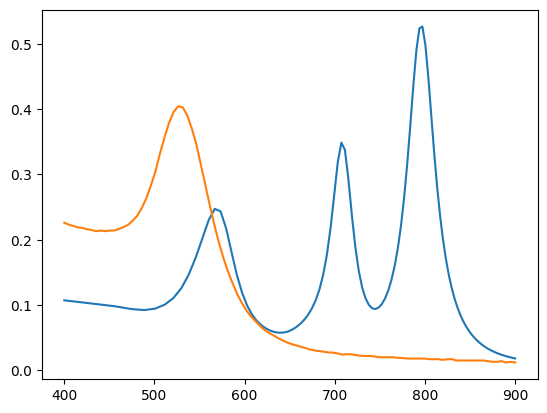

In [12]:
from activephasemap.simulators import UVVisExperiment
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]
expt = UVVisExperiment(design_space_bounds, "../data/")
expt.read_iter_data(14)
expt.generate(use_spline=True)

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_mixture.detach().numpy())
ax.plot(expt.wl, expt.spectra_normalized[5,:])
plt.show()


In [9]:
def objective_sphere(x):
    error = 0.0
    for i, wl in enumerate(wavelengths):
        s_query = sphere_extinction(wl, *x)
        error += (s_query-spectra_sphere[i])**2
        
    return error

design_space_bounds = [(2.0, 20.0), # sphere radius (mu)
                       (1.0, 1.5), # dieletric constant for sphereical medium
                       ]

In [10]:
def objective_nanorod(x):
    error = 0.0
    s_query = torch.zeros_like(wavelengths)
    for i, wl in enumerate(wavelengths):
        s_query[i] = nanorod_extinction(wl, *x)
    error = (s_query-spectra_nanorod)**2 
           
    return error.sum()


design_space_bounds = [(20.0, 60.0), # nanorod length (mu)
                       (20.0, 40.0), # nanorod radius (mu)
                       (2.0, 5.0), # dieletric constant for sphereical medium
                       ]


In [26]:
def objective_mixed(x):
    error = 0.0
    s_query = torch.zeros_like(wavelengths)
    for i, wl in enumerate(wavelengths):
        s_sphere = x[-1]*sphere_extinction(wl, *x[:2])
        s_nanorod = (1-x[-1])*nanorod_extinction(wl, *x[2:-1])
        s_query[i] = s_sphere+s_nanorod
    error = (s_query-spectra_mixture)**2 
           
    return error.sum()

design_space_bounds = [(2.0, 20.0), # sphere radius (mu)
                       (1.0, 1.5), # dieletric constant for sphereical medium
                       (20.0, 60.0), # nanorod length (mu)
                       (20.0, 40.0), # nanorod radius (mu)
                       (2.0, 5.0), # dieletric constant for nanorod medium
                       (0.0, 1.0), # mixed model weights
                       ]

In [31]:
TRAINING_ITERATIONS = 30
NUM_RESTARTS = 10

best_error = np.inf 
bounds = torch.tensor(design_space_bounds).transpose(-1, -2)
samples = draw_sobol_samples(bounds=bounds, n=NUM_RESTARTS, q=1).squeeze()
for i in range(NUM_RESTARTS):
    X = samples[i,...].clone().detach()
    X.requires_grad_(True)
    optimizer = torch.optim.Adam([X], lr=0.01)
    print("Run %d/%d"%(i, NUM_RESTARTS))
    
    for j in range(TRAINING_ITERATIONS):
        optimizer.zero_grad()
        loss = objective_mixed(X)
        loss.backward() 
        optimizer.step()

        # clamp values to the feasible set
        for k, (lb, ub) in enumerate(zip(*bounds)):
            X.data[..., k].clamp_(lb, ub) 

        if (j + 1) % 1 == 0:
            print(f"Iteration {j+1:>3}/{TRAINING_ITERATIONS:>3} - Loss: {loss.item():>4.3f}; dX: {X.grad.squeeze()}")

        if loss.item()<1e-2:
            best_error = loss.item()
            best_X = X.clone().detach()
            print(best_X)
            break
        elif loss.isnan():
            break

    if loss.item()<best_error:
        best_error = loss.item()
        best_X = X.clone().detach()

    

Run 0/10
Iteration   1/ 30 - Loss: 5.152; dX: tensor([ 9.7024e-01,  1.1027e+01, -1.6632e-03,  3.4130e-03,  8.2601e-03,
         1.0641e+01])
Iteration   2/ 30 - Loss: 4.930; dX: tensor([ 9.2604e-01,  1.0598e+01, -1.8861e-03,  3.8728e-03,  1.0361e-02,
         1.0234e+01])
Iteration   3/ 30 - Loss: 4.716; dX: tensor([ 8.8343e-01,  1.0181e+01, -2.0713e-03,  4.2556e-03,  1.2594e-02,
         9.8386e+00])
Iteration   4/ 30 - Loss: 4.512; dX: tensor([ 8.4240e-01,  9.7769e+00, -2.2200e-03,  4.5638e-03,  1.4955e-02,
         9.4540e+00])
Iteration   5/ 30 - Loss: 4.316; dX: tensor([ 8.0292e-01,  9.3849e+00, -2.3335e-03,  4.8001e-03,  1.7440e-02,
         9.0806e+00])
Iteration   6/ 30 - Loss: 4.129; dX: tensor([ 7.6500e-01,  9.0052e+00, -2.4133e-03,  4.9672e-03,  2.0044e-02,
         8.7184e+00])
Iteration   7/ 30 - Loss: 3.950; dX: tensor([ 7.2859e-01,  8.6379e+00, -2.4608e-03,  5.0679e-03,  2.2762e-02,
         8.3675e+00])
Iteration   8/ 30 - Loss: 3.780; dX: tensor([ 6.9369e-01,  8.2830e+

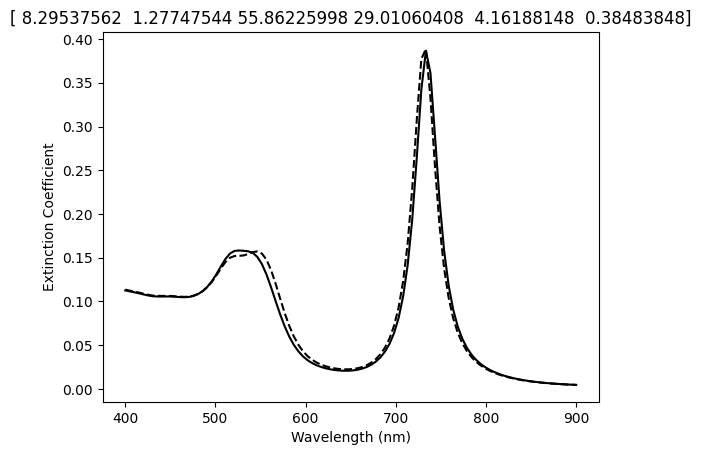

In [32]:
spectra_mixture_optimized = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    s_sphere = best_X[-1]*sphere_extinction(wl, *best_X[:2])
    s_nanorod = (1-best_X[-1])*nanorod_extinction(wl, *best_X[2:-1])
    spectra_mixture_optimized[i] = s_sphere+s_nanorod

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_mixture.detach().numpy(), color="k")
ax.plot(wavelengths, spectra_mixture_optimized.detach().numpy(), color="k", ls="--")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Extinction Coefficient")
ax.set_title(best_X.detach().numpy())
plt.show()

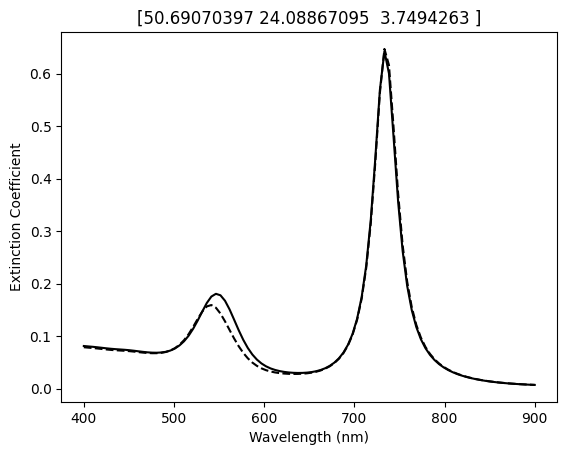

In [ ]:
spectra_nanorod_optimized = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_nanorod_optimized[i] = nanorod_extinction(wl, *best_X)

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_nanorod.detach().numpy(), color="k")
ax.plot(wavelengths, spectra_nanorod_optimized.detach().numpy(), color="k", ls="--")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Extinction Coefficient")
ax.set_title(best_X.detach().numpy())
plt.show()

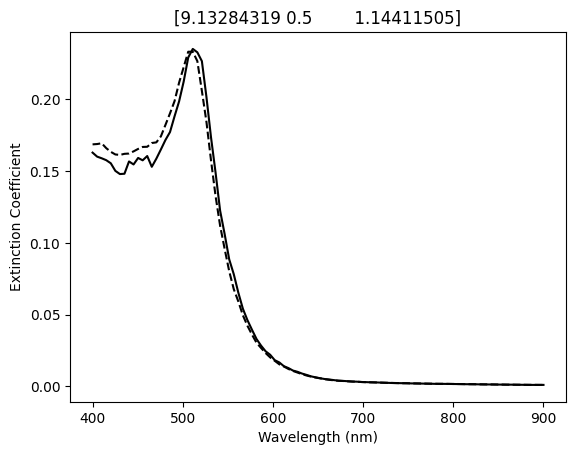

In [115]:
spectra_sphere_optimized = torch.zeros_like(wavelengths)
for i, wl in enumerate(wavelengths):
    spectra_sphere_optimized[i] = sphere_extinction(wl, *best_X)

fig, ax = plt.subplots()
ax.plot(wavelengths, spectra_sphere.detach().numpy(), color="k")
ax.plot(wavelengths, spectra_sphere_optimized.detach().numpy(), color="k", ls="--")
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Extinction Coefficient")
ax.set_title(best_X.detach().numpy())
plt.show()